The following code is an implementation of the Value class from the tutorial, based on memory and understanding.

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# introduction

a = 2.0
b = -3.5
c = 9.0
d = 1.5
e =  a + b
f = c*e
L = f + d

# Essentially what backproppagation does is 
# evaluating the derivative of L with respect to
# its constituent variables, i.e. a, b, c, d, e, f

To start, a Value class has to be created to store floats, and to allow extra operations on the specific value

In [163]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        # stores its operands
        self._children = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __add__(self, other): # other + self
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
             # reason for += is that the gradients will 
             # overwrite each other if same variable is used more than once
             self.grad += 1.0 * out.grad
             other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    

    def __radd__(self, other): # 2 + self
        return self + other


    def __neg__(self):
        return self * -1
    

    def __sub__(self, other):
        return self + (-other)
    

    def __rsub__(self, other):
        return other + (-self)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    

    def __rmul__(self, other): # other * self
        return self * other
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out


    def __truediv__(self, other): # self / other
        return self * other ** -1
    

    def __rtruediv__(self, other):
        return other * self ** -1


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
                
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    


In [156]:
a = Value(2.0)
b = Value(4.0)
print(4 / a)
print(a / 4)
print(a.exp())

Value(data=2.0)
Value(data=0.5)
Value(data=7.38905609893065)


In [70]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(5.0, label="c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"

In [158]:
# Visualisation of tree
from graphviz import Digraph

# Obtain nodes and edges from root node
def trace(root):
    nodes, edges = set(), set()
    def dfs(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                dfs(child)
    dfs(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # Left to Right graph

    nodes, edges = trace(root)
    for n in nodes:
        # create unique uid for node
        uid = str(id(n))
        # Create node in graph
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # create node of operation if its a result of one
            dot.node(name = uid + n._op, label = n._op)
            # connect operation to its result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect all nodes
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


In [72]:
def test():
    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(5.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(5.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data + h

    print((L2 - L1)/h)

test()


0.9999999999998899


| Var | exp                                 | grad |
|-----|-------------------------------------|------|
| L   | $\frac{dL}{dL}$ = 1                           | 1    |
| d   | $\frac{dL}{dd}$ = f                           | -2   |
| f   | $\frac{dL}{df}$ = d                           | -1   |
| e   | $\frac{dL}{de}$ = $\frac{dL}{dd}$ * $\frac{dd}{de}$ = -2 * 1 = -2 | -2   |
| c   | $\frac{dL}{dc}$ = $\frac{dL}{dd}$ * $\frac{dd}{dc}$ = -2 * 1 = -2 | -2   |
| b   | $\frac{dL}{db}$ = $\frac{dL}{de}$ * $\frac{de}{db}$ = -2 * 2 = -4 | -4    |
| a   | $\frac{dL}{da}$ = $\frac{dL}{de}$ * $\frac{de}{da}$ = -2 * -3 = 6 | 6   |

In [73]:
L.grad = 1.0
d.grad = -2.0
f.grad = -1.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0


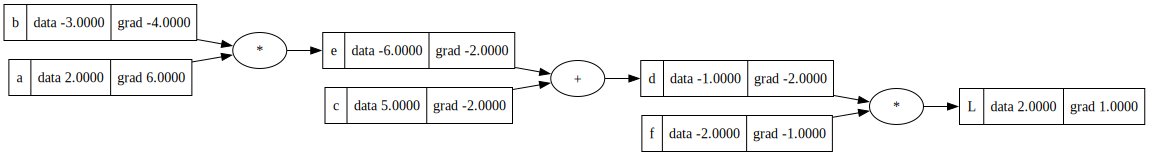

In [74]:
draw(L)

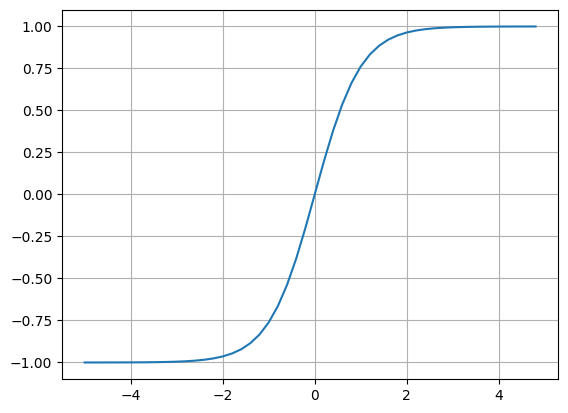

In [75]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

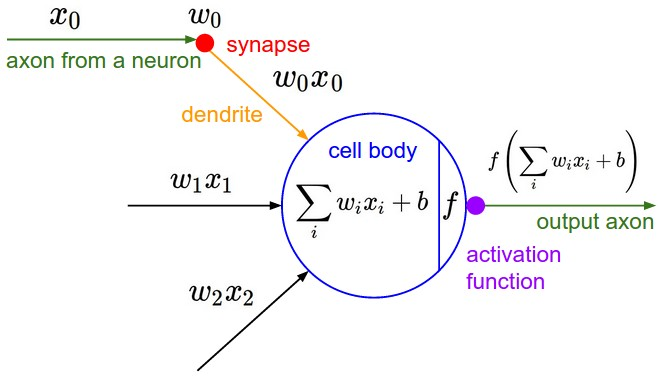

In [173]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

# o = n.tanh(); o.label = "o"
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.backward()

By manual calculation

| Var | exp                   | grad |
|-----|-----------------------|------|
| o   | $\frac{do}{do}$ = 1             | 1    |
| n   | $\frac{do}{dn}$ = 1 - $o^2$ = 0.5 | 0.5  |

In [167]:
o.grad = 1.0
n.grad = 0.5 # 1 - o.data**2

x1w1x2w2.grad = 0.5
b.grad = 0.5

x2w2.grad = 0.5
x1w1.grad = 0.5

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

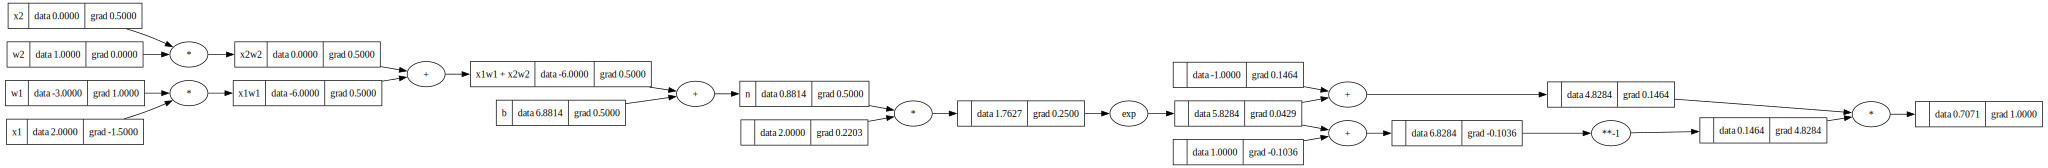

In [174]:
draw(o)